In [10]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.svm import SVC

## Part 1

In [11]:
def hough_circle_detection(image, min_radius, max_radius, skip_value, min_distance_penalty=0.8, threshold=140):
    """
    Detects circles in an image using the Hough Circle Transform.

    Args:
        image: The input image.
        min_radius: The minimum radius of circles to detect.
        max_radius: The maximum radius of circles to detect.
        skip_value: The step size for radius values.
        min_distance_penalty: The minimum distance penalty for suppressing overlapping circles.
        threshold: The minimum number of votes for a circle to be considered valid.

    Returns:
        A list of detected circles, where each circle is represented as a tuple (x, y, r), where
        x and y are the coordinates of the circle's center and r is the circle's radius.
    """

    # Keeping original dimensions to later convert.
    original_height, original_width = image.shape[:2]

    # Calculate the resize ratio based on the image size
    resize_ratio = min(1.0, 296.0 / max(original_height, original_width))

    # Resize the image
    resized_image = cv2.resize(image, None, fx=resize_ratio, fy=resize_ratio)

    # Convert the image to grayscale
    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)

    # Blurring image for better edge detection
    blurred = cv2.GaussianBlur(gray, (7, 7), 1)

    # Apply Canny edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Hough Transform for Circle Detection
    accumulator = np.zeros((gray.shape[0], gray.shape[1], max_radius - min_radius + 1))

    cos_theta = np.cos(np.radians(np.arange(360)))
    sin_theta = np.sin(np.radians(np.arange(360)))

    edge_points = np.column_stack(np.where(edges > 0))

    # Iterate over all possible circles (theta and radius)
    for theta in range(0, 360):
        for r in range(min_radius, max_radius + 1, skip_value):
            a = np.round(edge_points[:, 0] - r * cos_theta[theta]).astype(int)
            b = np.round(edge_points[:, 1] - r * sin_theta[theta]).astype(int)

            valid_points = np.where((a >= 0) & (a < edges.shape[0]) & (b >= 0) & (b < edges.shape[1]))

            a = a[valid_points]
            b = b[valid_points]

            # Accumulate votes for each circle
            accumulator[a, b, r - min_radius] += 1

    # Find circles with votes above the threshold
    circle_coordinates = np.where(accumulator >= threshold)
    circles_resized = list(zip(circle_coordinates[0], circle_coordinates[1], circle_coordinates[2] + min_radius))

    circles_resized = apply_distance_penalty(circles_resized, min_distance_penalty)

    # Transform the detected circles back to the original frame
    circles_original = [
        (int(x / resize_ratio), int(y / resize_ratio), int(radius / resize_ratio))
        for x, y, radius in circles_resized
    ]

    if circles_original is not None:
        return circles_original
    else:
        return None

def apply_distance_penalty(circles, min_distance_penalty):
    """
    Suppresses overlapping circles by removing circles that are too close to each other.

    Args:
        circles: A list of detected circles, where each circle is represented as a tuple (x, y, r), where
        x and y are the coordinates of the circle's center and r is the circle's radius.
        min_distance_penalty: The minimum distance penalty for suppressing overlapping circles.

    Returns:
        A list of filtered circles.
    """

    # Sort circles by radius in descending order
    # Doing this to draw only outer circle of coins for later to count them in part 2 easily
    sorted_circles = sorted(circles, key=lambda x: x[2], reverse=True)

    selected_circles = []

    for circle in sorted_circles:
        x, y, r = circle
        # Check distance differences
        if not any(
            np.sqrt((x - cx) ** 2 + (y - cy) ** 2) < min_distance_penalty * (r + cr)
            for cx, cy, cr in selected_circles
        ):
            selected_circles.append(circle)

    return selected_circles

In [12]:
def process_images(input_folder, output_folder, min_radius, max_radius, skip_value):
    """
    Processes a folder of images by detecting circles in each image and saving the resulting images to an output folder.

    Args:
        input_folder: The path to the input folder containing the images to process.
        output_folder: The path to the output folder where the processed images will be saved.
        min_radius: The minimum radius of circles to detect.
        max_radius: The maximum radius of circles to detect.
        skip_value: The step size for radius values.
    """

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Process each image in the input folder
    for filename in tqdm(os.listdir(input_folder)):
        # Read the image
        image = cv2.imread(os.path.join(input_folder, filename))

        # Detect circles
        detected_circles = hough_circle_detection(
            image.copy(), min_radius=min_radius, max_radius=max_radius, skip_value=skip_value
        )

        # Draw circles on the original image
        for circle in detected_circles:
            center = (circle[1], circle[0])  # Swap x and y coordinates
            radius = circle[2]
            if "Test" in input_folder:
                cv2.circle(image, center, radius, (0, 255, 0), 12)
            else:
                cv2.circle(image, center, radius, (0, 255, 0), 6)
        # Save the result in the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, image)

In [13]:
# Set the input and output folders and radius ranges
datasets = [
    ("TestV", "TestV_Hough", 7, 30, 1),
    ("TestR", "TestR_Hough", 7, 30, 1),
    ("Train", "Train_Hough", 60, 148, 4),
]

# Process each dataset
for input_folder, output_folder, min_radius, max_radius, skip_value in datasets:
    print(f"---------Processing {input_folder} Folder---------")
    process_images(input_folder, output_folder, min_radius, max_radius, skip_value)
    print(f"---------{input_folder} Folder Finished---------")

print("All folders processed.")

---------Processing TestV Folder---------


100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


---------TestV Folder Finished---------
---------Processing TestR Folder---------


100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


---------TestR Folder Finished---------
---------Processing Train Folder---------


100%|██████████| 56/56 [01:09<00:00,  1.23s/it]

---------Train Folder Finished---------
All folders processed.


### Circle Visualization

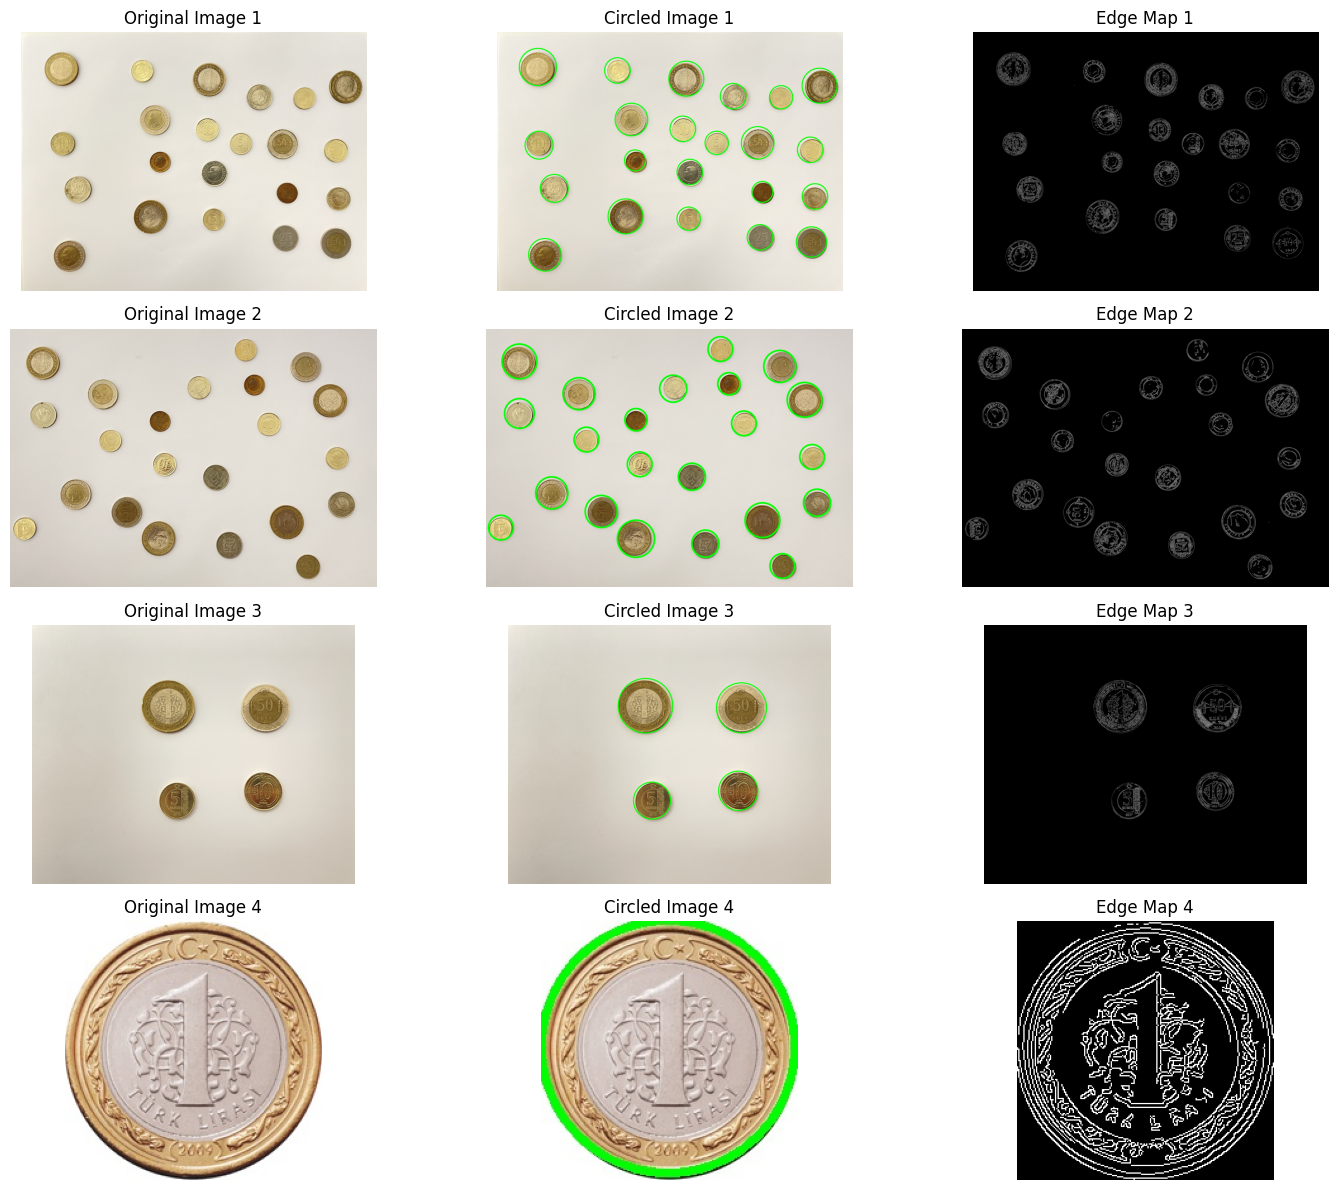

In [14]:
original_images = [cv2.imread("TestV/01.jpg"),
                   cv2.imread("TestR/02.jpg"),
                   cv2.imread("TestV/12.jpg"),
                   cv2.imread("Train/1TL_obverse_1.jpg")]

circled_images = [cv2.imread("TestV_Hough/01.jpg"),
                  cv2.imread("TestR_Hough/02.jpg"),
                  cv2.imread("TestV_Hough/12.jpg"),
                  cv2.imread("Train_Hough/1TL_obverse_1.jpg")]

# Create a 4x3 subplot layout
fig, axs = plt.subplots(4, 3, figsize=(15, 12))

# Iterate over the images and plot them
for i, (original_image, circled_image) in enumerate(zip(original_images, circled_images)):
    axs[i, 0].imshow(original_image[:, :, ::-1])
    axs[i, 0].set_title(f"Original Image {i+1}")
    axs[i, 0].axis("off")

    axs[i, 1].imshow(circled_image[:, :, ::-1])
    axs[i, 1].set_title(f"Circled Image {i+1}")
    axs[i, 1].axis("off")

     # Blur the original image for edge detection
    blurred_image = cv2.GaussianBlur(original_image, (19, 19), 1)

    # Calculate edge map using Canny edge detection
    edge_map = cv2.Canny(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2GRAY), 50, 150)
    axs[i, 2].imshow(edge_map, cmap='gray')
    axs[i, 2].set_title(f"Edge Map {i+1}")
    axs[i, 2].axis("off")

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("hough_figure.jpg", dpi=400)
plt.show()


## Part 2

In [15]:
def custom_hog(img, num_orientations=9, pixels_per_cell=(8, 8)):
    """
    Calculates the Histogram of Oriented Gradients (HOG) features for an image.

    Args:
        img: The input image.
        num_orientations: The number of orientations to use for the histogram bins.
        pixels_per_cell: The size of each cell in pixels.

    Returns:
        A numpy array of HOG features.
    """

    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Calculate gradients
    grad_x, grad_y = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=1), cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=1)

    # Calculate magnitude and direction of gradients
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    direction = np.arctan2(grad_y, grad_x) * (180 / np.pi) % 180

    # Create histogram bins based on orientations
    bins = np.int32(num_orientations * direction / 180.0)

    # Calculate histogram of gradients for each cell
    cell_size_x, cell_size_y = pixels_per_cell

    hog_histogram = np.zeros((gray_img.shape[0] // cell_size_x, gray_img.shape[1] // cell_size_y, num_orientations))

    for i in range(hog_histogram.shape[0]):
        for j in range(hog_histogram.shape[1]):
            cell_magnitude = magnitude[i * cell_size_x:(i + 1) * cell_size_x, j * cell_size_y:(j + 1) * cell_size_y]
            cell_direction = bins[i * cell_size_x:(i + 1) * cell_size_x, j * cell_size_y:(j + 1) * cell_size_y]

            hog_histogram[i, j, :] = [np.sum(cell_magnitude[cell_direction == b]) for b in range(num_orientations)]

    # Normalize the histogram
    hog_features = hog_histogram.flatten()

    return hog_features

In [16]:
def train_svm():
    """
    Trains a Support Vector Machine (SVM) classifier for coin detection using HOG features.

    Returns:
        svm_model: The trained SVM model.
    """

    # Lists to store features and labels for training
    train_features = []
    train_labels = []

    # Process each image in the "Train" folder
    for filename in tqdm(os.listdir("Train")):
        # Read the image
        image = cv2.imread(os.path.join("Train", filename))

        # Resize the image to a consistent size
        image = cv2.resize(image, dsize=(256, 256))

        # Extract HOG features from the image
        features = custom_hog(image)

        # Add the features and labels to the training data
        train_features.append(features)
        train_labels.append('_'.join(filename.split("_")[:-1]))

    # Reshape the feature vectors into a 2D array
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)

    print("Features shape:", train_features.shape)

    # Train an SVM model using a linear kernel
    svm_model = SVC(kernel="linear", C=1.0, random_state=42)
    svm_model.fit(train_features, train_labels)

    print(f"------Training Finished------")

    return svm_model

In [17]:
def detect_and_draw_coins(test_folder, output_folder, svm_model, min_radius, max_radius):
    """
    Detects and draws coins in images using the Hough Circle Transform and an SVM classifier.

    Args:
        test_folder: The path to the folder containing the test images.
        output_folder: The path to the folder where the processed images will be saved.
        svm_model: The trained SVM model for coin classification.
        min_radius: The minimum radius of circles to detect.
        max_radius: The maximum radius of circles to detect.

    Returns:
        None
    """

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Process each image in the test folder
    for filename in tqdm(os.listdir(test_folder)):
        # Read the image
        image = cv2.imread(os.path.join(test_folder, filename))

        # Detect circles using the Hough Circle Transform method
        detected_circles = hough_circle_detection(image.copy(), min_radius=min_radius, max_radius=max_radius, skip_value=1)

        # Initialize lists to store results for each circle
        circle_results = []

        # Process each detected circle
        for circle in detected_circles:
            x, y, r = circle
            center = (y, x)  # Swap x and y coordinates
            radius = r

            # Extract a cropped image of the circle
            crop_img = image[x-r:x+r, y-r:y+r]

            # Resize the cropped image to a size that model expects.
            crop_img = cv2.resize(crop_img, dsize=(256, 256))

            # Extract custom HoG features for the circle
            features = custom_hog(crop_img)
            features = features.reshape(1, -1)

            # Predict using the trained SVM model
            prediction = svm_model.predict(features)

            # Draw the circle on the original image
            cv2.circle(image, center, radius, (0, 255, 0), 6)

            # Draw the prediction on the image
            cv2.putText(image, f"Coin: {prediction[0]}", (center[0] - radius, center[1] - radius - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 2)

            # Save the results for the circle
            circle_results.append((prediction[0], center, radius))

        # Save the processed image to the output folder
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, image)

    # Finished
    return

In [18]:
# Set the input and output folders and radius ranges
test_folder = "TestV"
output_folder = "TestV_HoG"
min_radius = 7
max_radius = 30

# Train an SVM model using HOG features of Train Dataset
trained_svm_model = train_svm()

# Detect and draw coins in the test images
detect_and_draw_coins(test_folder, output_folder, trained_svm_model, min_radius, max_radius)

100%|██████████| 56/56 [00:02<00:00, 18.73it/s]


Features shape: (56, 9216)
------Training Finished------


100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


### Bonus Part

In [19]:
# Set the input and output folders and radius ranges
test_folder = "TestR"
output_folder = "TestR_HoG"
min_radius = 7
max_radius = 30

# Train an SVM model using HOG features of Train Dataset
trained_svm_model = train_svm()

# Detect and draw coins in the test images
detect_and_draw_coins(test_folder, output_folder, trained_svm_model, min_radius, max_radius)

100%|██████████| 56/56 [00:02<00:00, 18.82it/s]


Features shape: (56, 9216)
------Training Finished------


100%|██████████| 4/4 [00:07<00:00,  1.78s/it]


### Visualize Detected Classes

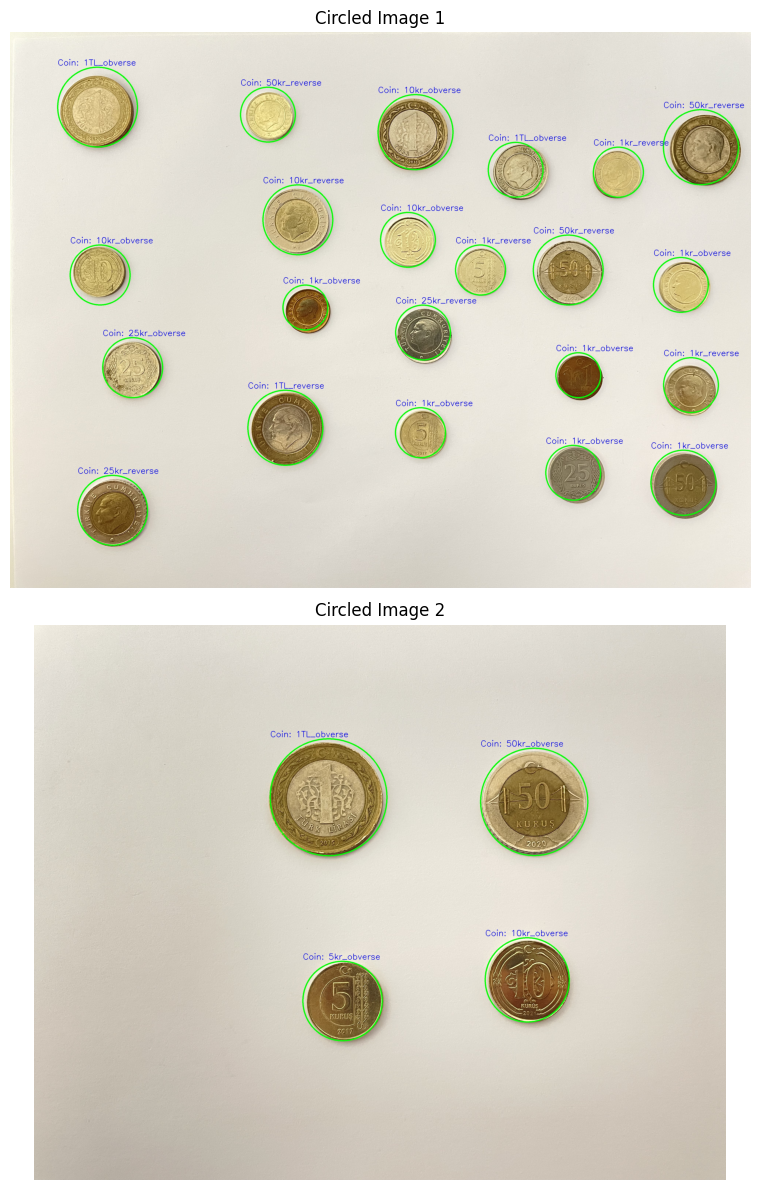

In [20]:
circled_images = [cv2.imread("TestV_HoG/01.jpg"),
cv2.imread("TestV_HoG/12.jpg")]


# Create a 2x1 subplot layout
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Iterate over the images and plot them
for i, circle_image in enumerate(circled_images):

    axs[i].imshow(circle_image[:,:,::-1])
    axs[i].set_title(f"Circled Image {i+1}")
    axs[i].axis("off")


# Adjust layout and show the plot
plt.tight_layout()
plt.savefig("hog_results.jpg", dpi=400)
plt.show()